In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import numpy as np
import uproot
import scipy

processing file: run_020/gap_10.0_mesh_340.0_drift_50.0.root


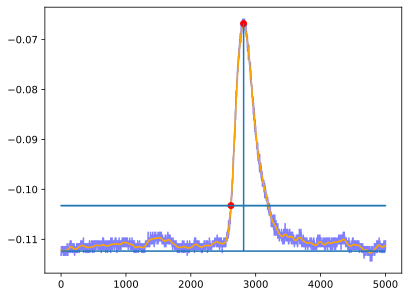

In [42]:
file = "run_020/gap_10.0_mesh_340.0_drift_50.0.root"
print(f"processing file: {file}")
data = dict()
with uproot.open(file) as f:
    tree = f["t"]
    for key in tree.keys():
        data[key] = tree[key].array()

for i in range(1):
    x = data["time"][i]
    y_original = data["CH3"][i]
    N = 50
    y = scipy.ndimage.uniform_filter1d(y_original, size=N)

    plt.plot(y_original, color="blue", alpha=0.5)
    plt.plot(y, color="orange")

    peaks, _ = scipy.signal.find_peaks(y, distance=500)
    prominences = scipy.signal.peak_prominences(y, peaks)[0]

    argmax = np.argmax(prominences)
    peak = peaks[argmax]
    prominence = prominences[argmax]
    peak_base = y[peak] - prominence

    plt.plot([peak], y[peak], "ro")

    plt.vlines(x=peak, ymin=peak_base, ymax=y[peak])

    plt.hlines(y=peak_base, xmin=0, xmax=len(y))
    plt.hlines(y=peak_base + prominence * 0.20, xmin=0, xmax=len(y))

    h_line = np.ones(len(y)) * (peak_base + prominence * 0.20)
    idx = sorted(np.argwhere(np.diff(np.sign(y - h_line))).flatten())[0]
    plt.plot(idx, h_line[idx], 'ro')
    plt.plot(h_line)
    plt.savefig("fit.svg")
    plt.show()

In [20]:
def peak_analysis(x: np.ndarray):
    N = 50  # reduce noise
    x = scipy.ndimage.uniform_filter1d(x, size=N)

    peaks, _ = scipy.signal.find_peaks(x, distance=len(x) // 10)
    prominences = scipy.signal.peak_prominences(x, peaks)[0]

    # get the highest peak
    argmax = np.argmax(prominences)
    peak = peaks[argmax]
    # compute relative peak height (prominence) and base
    prominence = prominences[argmax]
    peak_base = x[peak] - prominence

    h_line = np.ones(len(x)) * (peak_base + prominence * 0.20)
    idx = sorted(np.argwhere(np.diff(np.sign(x - h_line))).flatten())[0]
    # idx = peak

    return peak, idx, peak_base


def drift_times_analysis(times: np.ndarray, bins: int = 50):
    def reject_outliers(data, m=10.):
        d = np.abs(data - np.median(data))
        mdev = np.median(d)
        s = d / mdev if mdev else 0.
        return data[s < m]

    def histogram_with_centers(_x: np.ndarray, **kwargs):
        counts, edges = np.histogram(_x, **kwargs)
        centers = 0.5 * (edges[:-1] + edges[1:])
        return centers, counts

    times = reject_outliers(times)

    x, y = histogram_with_centers(times, bins=bins)

    def fit_function(x, amplitude, center, sigma):
        return amplitude * np.exp(-(x - center) ** 2 / (2 * sigma ** 2))

    initial_guess = [np.max(y), np.median(times), np.std(times)]
    p, _ = scipy.optimize.curve_fit(fit_function, x, y, p0=initial_guess)

    return p[1], p[2]

In [25]:
import os
from pathlib import Path


def get_drift_voltage_from_file(filename):
    import re
    regex = re.compile(r"gap_10\.0_mesh_340\.0_drift_(\d+)(\.\d+)?\.root")
    match = regex.match(filename)
    return float(match.group(1))


files_dir_path = Path("2022_11_8_2p3_isobutane_argon")
files = [files_dir_path / file for file in os.listdir(files_dir_path)]
voltages = [get_drift_voltage_from_file(file.name) for file in files]

voltages, files = zip(*sorted(zip(voltages, files)))
voltages = np.array(voltages)

for file, voltage in zip(files, voltages):
    print(str(file), voltage)

2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_50.0.root 50.0
2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_60.0.root 60.0
2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_70.0.root 70.0
2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_80.0.root 80.0
2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_90.0.root 90.0
2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_100.0.root 100.0
2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_110.0.root 110.0
2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_120.0.root 120.0
2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_130.0.root 130.0
2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_140.0.root 140.0
2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_150.0.root 150.0
2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_160.0.root 160.0
2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_170.0.root 170.0
2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_180.0

In [26]:
drift_times = np.zeros(len(files))
drift_times_sigma = np.zeros(len(files))
voltages = np.array(voltages)

for entry, file in enumerate(files):
    print(f"processing file: {file}")
    data = dict()
    with uproot.open(file) as f:
        tree = f["t"]
        for key in tree.keys():
            data[key] = tree[key].array()

    times = np.zeros(len(data["time"]))
    for i in range(len(times)):
        x = data["time"][i] * 1E6  # us
        y = data["CH3"][i]
        peak, idx, peak_base = peak_analysis(y)
        # print(peak, idx, peak_base)
        time = x[idx]
        times[i] = time
        # plt.plot(x,y)
        # plt.plot(x[idx], y[idx], "ro")

        #plt.show()

    drift_time, drift_time_sigma = drift_times_analysis(times)
    drift_times[entry] = drift_time
    drift_times_sigma[entry] = drift_time_sigma


processing file: 2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_50.0.root
processing file: 2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_60.0.root
processing file: 2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_70.0.root
processing file: 2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_80.0.root
processing file: 2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_90.0.root
processing file: 2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_100.0.root
processing file: 2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_110.0.root
processing file: 2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_120.0.root
processing file: 2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_130.0.root
processing file: 2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_140.0.root
processing file: 2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_150.0.root
processing file: 2022_11_8_2p3_isobutane_argon\gap_10.0_mesh_340.0_drift_160.0.ro

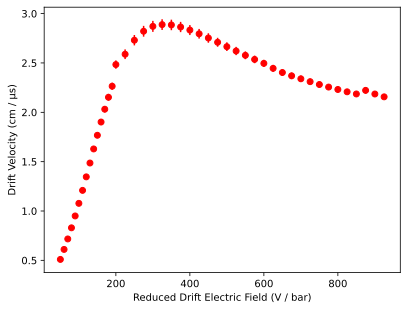

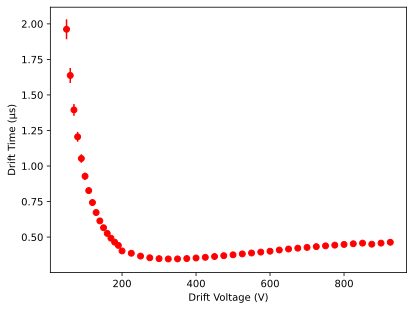

In [31]:
drift_gap = 1.0

drift_velocity = 1.0 / drift_times
drift_velocity_sigma = drift_times_sigma / drift_times ** 2

pressure = 1.0
drift_field = voltages / drift_gap / pressure

plt.errorbar(drift_field, drift_velocity, yerr=drift_velocity_sigma * 3, linestyle="", color="red")
plt.plot(drift_field, drift_velocity, "ro")
plt.xlabel("Reduced Drift Electric Field (V / bar)")
plt.ylabel("Drift Velocity (cm / μs)")
plt.savefig("drift_velocity.svg")
plt.show()

plt.errorbar(voltages, drift_times, yerr=drift_times_sigma * 5, linestyle="", color="red")
plt.plot(voltages, drift_times, "ro")
plt.xlabel("Drift Voltage (V)")
plt.ylabel("Drift Time (μs)")
plt.savefig("drift_times.svg")
plt.show()


In [22]:
voltage = 225
files_check = [f"2022_11_8_2p3_isobutane_argon/gap_10.0_mesh_340.0_drift_{voltage}.root",
               f"run_008/gap_10.0_mesh_340.0_drift_{voltage}.0.root"]

for entry, file in enumerate(files_check):
    print(f"processing file: {file}")
    data = dict()
    with uproot.open(file) as f:
        tree = f["t"]
        for key in tree.keys():
            data[key] = tree[key].array()

    times = np.zeros(len(data["time"]))
    for i in range(len(times)):
        x = data["time"][i] * 1E6  # us
        y = data["CH3"][i]
        peak, idx, peak_base = peak_analysis(y)
        time = x[idx]
        times[i] = time

    drift_time, drift_time_sigma = drift_times_analysis(times)
    print(drift_time, drift_time_sigma)


processing file: 2022_11_8_2p3_isobutane_argon/gap_10.0_mesh_340.0_drift_225.root
0.38631023974430895 0.0024381177682800633
processing file: run_008/gap_10.0_mesh_340.0_drift_225.0.root
0.38819523350974444 0.00506680645061284


In [316]:
def linlogspace(start: float, end: float, num: int):
    linlog = np.concatenate(
        (np.logspace(np.log10(start), np.log10(end), num // 2), np.linspace(start, end, num - num // 2)))

    tolerance = (lambda x: x[1] - x[0])(np.logspace(np.log10(start), np.log10(end), num))
    # remove very similar elements

    return linlog

